In [1]:
import tensorflow as tf
import numpy as np
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPool2D,Dropout,UpSampling2D,Concatenate
from tensorflow.keras import Model
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.python.keras import backend 


TensorFlow version: 2.7.0


In [2]:
'''
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")
'''

'\nmnist = tf.keras.datasets.mnist\n\n(x_train, y_train), (x_test, y_test) = mnist.load_data()\nx_train, x_test = x_train / 255.0, x_test / 255.0\n\n# Add a channels dimension\nx_train = x_train[..., tf.newaxis].astype("float32")\nx_test = x_test[..., tf.newaxis].astype("float32")\n'

In [3]:
#x_train.shape

In [4]:
f = h5py.File('top_dataset.h5', 'r')
for key in f.keys():
    print(key)
targets = f['targets']
iters=f['iters']

#data = group['targets'][()]

iters
targets


In [5]:
X_np=np.float32(iters)
y_np=np.float32(targets)




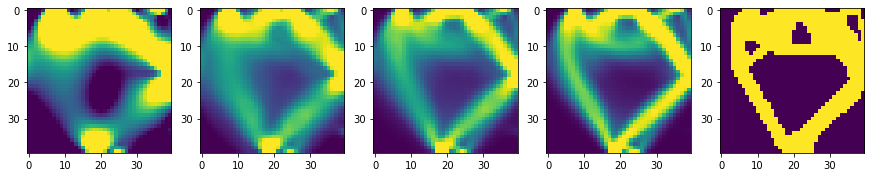

In [6]:
imN=37

f, axarr = plt.subplots(1,5)
f.set_figheight(15)
f.set_figwidth(15)

axarr[0].imshow(X_np[imN,:,:,0])
axarr[1].imshow(X_np[imN,:,:,1])
axarr[2].imshow(X_np[imN,:,:,2])
axarr[3].imshow(X_np[imN,:,:,3])
axarr[4].imshow(y_np[imN])

In [7]:
send_iter=5
X_np_5=X_np[:,:,:,send_iter-1:send_iter+1]
X_np_5[:,:,:,1]=X_np[:,:,:,send_iter-1]-X_np[:,:,:,send_iter-2]

10000

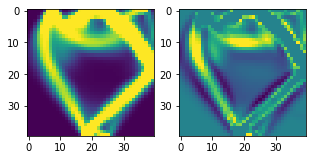

In [49]:

f, axarr = plt.subplots(1,2)
f.set_figheight(5)
f.set_figwidth(5)

axarr[0].imshow(X_np_5[imN,:,:,0])
axarr[1].imshow(X_np_5[imN,:,:,1])


In [50]:
n=5
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_np_5, y_np)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_np_5, y_np)).batch(32)

In [54]:
class Unet_Model(Model):
    def __init__(self):
        super(Unet_Model, self).__init__()
        self.conv1_1 = Conv2D(16, (3,3), padding='same', activation='relu')
        self.conv1_2 = Conv2D(16, (3,3), padding='same', activation='relu')
        #### Level 2
        self.pool2_1 = MaxPool2D((2, 2), padding='same') 
        self.conv2_1 = Conv2D(32, (3, 3), padding='same', activation='relu')
        self.drop2_1 = Dropout(0.1)
        self.conv2_2 = Conv2D(32, (3, 3), padding='same', activation='relu')

        ######### Level 3
        self.pool3_1 = MaxPool2D((2, 2), padding='same')
        self.conv3_1 = Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3_2 = Conv2D(64, (3, 3), padding='same', activation='relu')

        self.conv3_3 = Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3_4 = Conv2D(64, (3, 3), padding='same', activation='relu')
        self.up3_1 = UpSampling2D()

        #### Level 2
        self.conv2_3 = Conv2D(32, (3, 3), padding='same', activation='relu')
        self.drop2_2 = Dropout(0.1)
        self.conv2_4 = Conv2D(32, (3, 3), padding='same', activation='relu')
        self.up2_1 = UpSampling2D()

        # Level 1
        self.conv1_3 = Conv2D(16, (3, 3), padding='same', activation='relu')
        self.conv1_4 = Conv2D(16, (3, 3), padding='same', activation='relu')
        self.out = Conv2D(1, (3, 3), padding='same', activation='sigmoid')


    def call(self, x):
        print(x.shape)
        x = self.conv1_1(x)
        conv1_2 = self.conv1_2(x)

        x = self.pool2_1(conv1_2)
        x = self.conv2_1(x)
        x = self.drop2_1(x)
        x_conv2_2 = self.conv2_2(x)

        x = self.pool3_1(x_conv2_2)
        x = self.conv3_1(x)
        x = self.conv3_2(x)

        x = self.conv3_3(x)
        x = self.conv3_4(x)
        x = self.up3_1(x)

        x = Concatenate(axis=3)([x_conv2_2, x])
        x = self.conv2_3(x)
        x = self.drop2_2(x)
        x = self.conv2_4(x)
        x = self.up2_1(x)
        x = Concatenate(axis=3)([conv1_2, x])
        x = self.conv1_3(x)
        x = self.conv1_4(x)
        x = self.out(x)
        return x

# Create an instance of the model
model = Unet_Model()

In [55]:
#conf_loss = tf.losses.LogCosh(output_true, output_pred, reduction=tf.losses.Reduction.MEAN)
#vol_loss = tf.square(tf.reduce_mean(output_true - output_pred))
#loss = conf_loss + vol_coeff * vol_loss


#loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #log loss ele necese
loss_object = tf.keras.losses.LogCosh()
optimizer = tf.keras.optimizers.Adam()


In [56]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.MeanSquaredError(name='train_accuracy')
train_IoU_accuracy = tf.keras.metrics.MeanIoU(num_classes=2,name='IoU')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.MeanSquaredError(name='test_accuracy')
test_IoU_accuracy = tf.keras.metrics.MeanIoU(num_classes=2,name='IoU')


In [57]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    predictions_bin=tf.round(predictions)
    train_loss(loss)
    train_accuracy(labels, predictions)
    train_IoU_accuracy(labels, predictions_bin)

In [58]:
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    predictions=tf.keras.backend.round(predictions)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    test_IoU_accuracy(labels, predictions)

In [60]:
EPOCHS=10
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_IoU_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_IoU_accuracy.reset_states()


    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result():.2f}, '
    f'MSE: {train_accuracy.result() * 100:.2f}, '
    f'Accuracy IoU: {train_IoU_accuracy.result() * 100:.2f}, '
    f'Test Loss: {test_loss.result():.2f}, '
    f'Test MSE: {test_accuracy.result() * 100:.2f}'
    f'Test IoU Accuracy: {test_IoU_accuracy.result() * 100:.2f}'
    )


(32, 40, 40, 2)
(32, 40, 40, 2)
(16, 40, 40, 2)
(32, 40, 40, 2)
(16, 40, 40, 2)
Epoch 1, Loss: 0.03, MSE: 5.61, Accuracy IoU: 85.92, Test Loss: 0.03, Test MSE: 6.03Test IoU Accuracy: 88.63
Epoch 2, Loss: 0.02, MSE: 4.25, Accuracy IoU: 88.82, Test Loss: 0.03, Test MSE: 5.78Test IoU Accuracy: 89.08
Epoch 3, Loss: 0.02, MSE: 4.11, Accuracy IoU: 89.15, Test Loss: 0.02, Test MSE: 5.61Test IoU Accuracy: 89.38
Epoch 4, Loss: 0.02, MSE: 4.02, Accuracy IoU: 89.39, Test Loss: 0.02, Test MSE: 5.54Test IoU Accuracy: 89.50
Epoch 5, Loss: 0.02, MSE: 3.94, Accuracy IoU: 89.58, Test Loss: 0.02, Test MSE: 5.39Test IoU Accuracy: 89.77
Epoch 6, Loss: 0.02, MSE: 3.89, Accuracy IoU: 89.72, Test Loss: 0.02, Test MSE: 5.37Test IoU Accuracy: 89.81
Epoch 7, Loss: 0.02, MSE: 3.84, Accuracy IoU: 89.85, Test Loss: 0.02, Test MSE: 5.25Test IoU Accuracy: 90.02
Epoch 8, Loss: 0.02, MSE: 3.79, Accuracy IoU: 89.97, Test Loss: 0.02, Test MSE: 5.19Test IoU Accuracy: 90.13
Epoch 9, Loss: 0.02, MSE: 3.75, Accuracy IoU: 90

In [61]:
train_ds

<BatchDataset shapes: ((None, 40, 40, 2), (None, 40, 40, 1)), types: (tf.float32, tf.float32)>

In [62]:
tst=model(images,training=False)
print(f'MSE: {test_accuracy(labels, tst):.2f}, ')
print(f'IOU: {test_IoU_accuracy(labels, tst) :.2f}, ')

tst=tst.numpy()
tst=np.round(tst)
print(tst.shape)

(16, 40, 40, 2)
MSE: 0.05, 
IOU: 0.90, 
(16, 40, 40, 1)


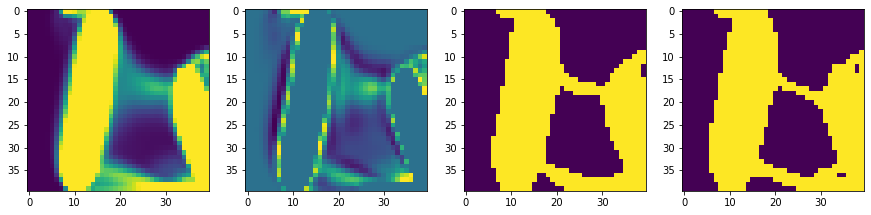

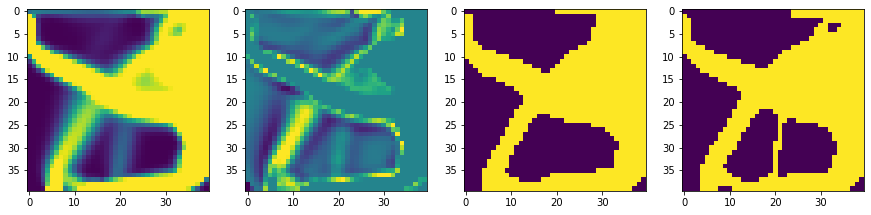

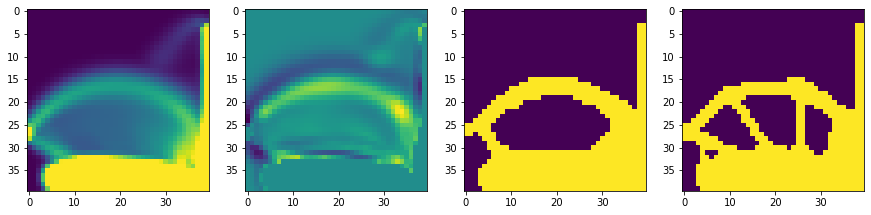

In [63]:
for i in range(3):
    f, axarr = plt.subplots(1,4)
    f.set_figheight(15)
    f.set_figwidth(15)

    axarr[0].imshow(images[i,:,:,0])
    axarr[1].imshow(images[i,:,:,1])
    axarr[2].imshow(tst[i,:,:,0])
    axarr[3].imshow(labels[i])


In [19]:
#tst[0,:,:,]